<a href="https://colab.research.google.com/github/sudipta-on/Quantum-Many-Body-Problem-using-Netket/blob/main/Hubbard_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $$\textbf{Fermionic Quantum Many-Body System using NetKet}$$
$\qquad \qquad \qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad\qquad \text{ - Sudipta Majumder}$

$17 $ $\text{July},2024$

We will start by introducing fermionic operators and how to work with them in NetKet. We will then proceed to implement and optimize three different wave functions:
- a Slater determinant wave function,
- a Neural Jastrow-Slater state, and
- a Slater Backflow neural wave function.

## 0. Installing and Importing NetKet

In [ ]:
!pip install netket --quiet --use-deprecated=legacy-resolver

In [ ]:
import netket as nk
import netket.experimental as nkx
import time

Fermionic operators are fundamental to describing quantum systems with fermions (e.g., electrons). NetKet provides tools to work with these operators efficiently.
We will work with a Hamiltonian of spinless fermions on a two-dimensional lattice:

$$
\mathcal{H} = -t \sum_{\langle i,j \rangle } \left( c^{\dagger}_i c_j + c^{\dagger}_j c_i \right ) + V \sum_{\langle i,j \rangle } n_i n_j
$$
Here, $\langle i,j \rangle $ denotes nearest-neighbors on a square lattice of $N=L\times L$ sites, $c_i (c^{\dagger}_i)$ are destruction (creation) fermionic operators on site $i$, whereas $n_i=c^{\dagger}_i c_i$ are density operators.

## 1. Defining the lattice and the Hilbert space:

In [ ]:
L = 4  # Side of the square
graph = nk.graph.Square(L)
N = graph.n_nodes

In [ ]:
print(f'Total number of sites on the lattice: {N}')

Total number of sites on the lattice: 16


We now define also the Hilbert space associated with a system of $N_f$ spinless fermions:

In [ ]:
N_f = 5

hi = nkx.hilbert.SpinOrbitalFermions(N, s=None, n_fermions=N_f)

To describe the Hamiltonian of our quantum system, we need to work with the fermionic operators associated with the Hilbert space defined above. These operators include creation (cdag), annihilation (c), and number (nc) operators. We will use these operators to build our Hamiltonian.

In [ ]:
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc

With these operators, we can now construct the Hamiltonian for our system. In this example, we have a tight-binding hopping term proportional to $t$ and a density-density interaction term proportional to $V$. We can easily define the Hamiltonian by adding terms one by one looping over the edges of the lattice:


In [ ]:
t = 1.0
V = 4.0

H = 0.0
for (i, j) in graph.edges():
    H -= t * (cdag(hi,i) * c(hi,j) + cdag(hi,j) * c(hi,i))  # look on the order of cdag and c
    H += V * nc(hi,i) * nc(hi,j)

## 2. Exact Diagonalization or Configuration Interaction method

Since the system is relatively small, the Hilbert space is also not too big, and we can still use exact diagonalization to compute the ground state energy. This is achieved by first converting the Hamiltonian to a sparse matrix, and then diagonalizing it with scipy:

In [ ]:
# Convert the Hamiltonian to a Sparse matrix
sp_h = H.to_sparse()

In [ ]:
from scipy.sparse.linalg import eigsh

eig_vals, eig_vecs = eigsh(sp_h, k = 2, which = 'SA')

E_gs = eig_vals[0]

print(f'Exact ground state energy: {E_gs}')

Exact ground state energy: -6.8590135543195805


## 3. Slater Determinant

Now, let's move on to defining and optimizing a simple variational wave function based on a mean-field state: the Slater determinant.

Formally, we can write the state as filling up $N_{\mathrm{f}}$ orbitals:

$$
|\Phi_s\rangle = \Pi_{\alpha=1}^{N_{\mathrm{f}}} \phi^{\dagger}_{\alpha} |0\rangle,
$$

where $|0\rangle$ is the vacuum state and the single-particle orbitals are created by the operators $\phi^{\dagger}_{\alpha}$. In turn, these creation operators are, in general, a linear combination of the original creation operators:

$$
\phi^{\dagger}_{\alpha} = \sum_i M_{\alpha, i} c^{\dagger}_i.
$$

The rectangular ($N\times N_{\mathrm{f}}$) matrix $M$ constitutes a set of free variational parameters (Where $N$ is the number of orbitals and $N_{\mathrm{f}}$ the number of fermions).

It can be shown that the amplitudes of the wave function in the computational basis $|n_1,\dots,n_N\rangle$ are determinants:

$$
\langle n_1,\dots,n_N |\Phi_s\rangle = \mathrm{det}\left\{A(\bf{n})\right\},
$$

where the $N_{\mathrm{f}}\times N_{\mathrm{f}}$ matrix is

$$
A(n)_{\alpha,\beta} = M_{R_{\alpha}(\bf{n}), \beta},
$$

where $R_{\alpha}(\bf{n})$ denotes the index of the $\alpha$-th occupied site (non-zero $n_i$) in $\bf{n}=(n_1,\dots,n_N)$.
This can also be interepted as selecting $N_\mathrm{f}$ rows of the matrix $M$ in corresponding to the $N_\mathrm{f}$ occupied orbitals.


To write down this variational amplitudes, we start by defining a convenience function to compute the logarithm of the determinant of a matrix, in the complex domain, and using jax:

In [ ]:
import jax
import jax.numpy as jnp

def _logdet_cmplx(A):
    '''We can also call this function from the netket module as `nk.jax.logdet_cmplx`. '''
    sign, logabsdet = jnp.linalg.slogdet(A)
    return logabsdet.astype(complex) + jnp.log(sign.astype(complex))

In [ ]:
import flax.linen as nn
from netket.utils.types import NNInitFunc
from netket.nn.masked_linear import default_kernel_init
from typing import Any, Callable, Sequence
from functools import partial
DType = Any


class LogSlaterDeterminant(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):
        # the N x Nf matrix of the orbitals
        M = self.param('M', self.kernel_init, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), self.param_dtype)

        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Find the positions of the occupied orbitals
            R = n.nonzero(size=self.hilbert.n_fermions)[0]

            # Extract the Nf x Nf submatrix of M corresponding to the occupied orbitals
            A = M[R]

            return _logdet_cmplx(A)

        return log_sd(n)

This Flax module defines the variational parameters to be the rectangular matrix $M$. In general, these parameters can be real or complex valued. In the following we will work with real parameters, for simplicity.

### Optimizing the Slater Determinant Wave Function

We now create an instance of the `LogSlaterDeterminant` class and of a suitable Monte Carlo Sampler to obtain expected values using Variational Monte Carlo:

In [ ]:
# Create the Slater determinant model
model = LogSlaterDeterminant(hi)

# Define the Metropolis-Hastings sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

We also define the `VariationalState` necessary to compute expected values over the variational state using Monte Carlo sampling. We will use a total of 16 independent Markov Chains and $2^{12}$ samples per chain. We will also discard the first 16 samples of each chain, to allow thermalization:

In [ ]:
vstate = nk.vqs.MCState(sampler=sa, model=model, n_samples = 2**12, n_discard_per_chain=16)

In [ ]:
vstate.samples.shape

(16, 256, 16)

In [ ]:
vstate.samples[0,0]

Array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0.],      dtype=float64)

In [ ]:
# Define the optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Define a preconditioner
preconditioner = nk.optimizer.SR(diag_shift=0.05)

# Create the VMC (Variational Monte Carlo) driver
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

In [ ]:
# Construct the logger to visualize the data later on
slater_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
start = time.time()
gs.run(n_iter=300, out=slater_log)
end = time.time()
sd_time = end - start
print("## Slater Determinant Wave function")
print(f"Time taken: {sd_time} seconds")

sd_energy = vstate.expect(H)
sd_error = abs((sd_energy.mean - E_gs)/E_gs)
print(f"Optimized energy : {sd_energy}")
print(f"relative error   : {sd_error}")

  0%|          | 0/300 [00:00<?, ?it/s]

## Slater Determinant Wave function
Time taken: 265.2650525569916 seconds
Optimized energy : -5.089+0.000j ± 0.034 [σ²=4.353, R̂=1.0005]
relative error   : 0.2580067192020388


The mean field energy of the Slater Determinant is about 25% off in this case where interactions are strong, thus far from the single-particle regime in which the Slater Determinant is accurate.

## 4. Neural Jastrow-Slater Wave Function

To improve on the simple mean field wave function considered above, we can construct a variational state that is the product of a Slater determinant times a many-body neural Jastrow factor :

$$
\langle n_1,\dots,n_N |\Phi_s\rangle \times \exp(J(\bf{n})),
$$

where $J(\bf{n})$ is parameterized via a suitable neural network taking as inputs the occupation numbers $\bf{n}=(n_1,\dots,n_N)$ and returning a scalar. See also References [2] and [3], for example choices of the neural network part.

In the following, we will parameterize the neural Jastrow with a simple two-layer feedforward network consisting of real parameters only. This means that the neural Jastrow will not be able to change the overall sign of the wave function, but it will nonetheless be able to capture strong correlations by modifying the absolute value of the wave function amplitudes.

We define the corresponding variational wave function in the following Flax class:

In [ ]:
class LogNeuralJastrowSlater(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    hidden_units: int
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):

        @partial(jnp.vectorize, signature='(n)->()')
        def log_wf(n):
            #Bare Slater Determinant (N x Nf matrix of the orbital amplitudes)
            M = self.param('M', self.kernel_init, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), self.param_dtype)

            #Construct the Neural Jastrow
            J = nn.Dense(self.hidden_units, param_dtype=self.param_dtype)(n)
            J = jax.nn.tanh(J)
            J = J.sum()

            # Find the positions of the occupied orbitals
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            # Select the N rows of M corresponding to the occupied orbitals, obtaining the Nf x Nf slater matrix
            A = M[R]
            # compute the (log) determinant and add the Jastrow
            # (when exponentiating this becomes a product of the slater and jastrow terms)
            return _logdet_cmplx(A)+J

        return log_wf(n)

In [ ]:
# Create a Neural Jastrow Slater wave function
model = LogNeuralJastrowSlater(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
nj_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
start = time.time()
gs.run(n_iter=300, out=nj_log)
end = time.time()
nj_time = end - start
print("## Neural Jastrow Wave function")
print(f"Time taken: {nj_time} seconds")

nj_energy = vstate.expect(H)
nj_error = abs((nj_energy.mean - E_gs)/E_gs)
print(f"Optimized energy : {nj_energy}")
print(f"relative error   : {nj_error}")

  0%|          | 0/300 [00:00<?, ?it/s]

## Neural Jastrow Wave function
Time taken: 295.78839802742004 seconds
Optimized energy : -6.814+0.000j ± 0.011 [σ²=0.523, R̂=1.0015]
relative error   : 0.0065978970630699105


## 5. Neural-Backflow Wave Function

An alternative approach to go beyond the simple mean field approximation, and also effectively change the nodal structure of the wave functions is given by the Neural Backflow transformation of Reference [4].  
The idea is to promote the matrix $M$ appearing in the Slater determinant to be a function of all the occupation numbers, through a neural network. Specifically, we take an additive form of the backflow transformation:

$$
M^{\mathrm{bf}}_{\alpha,i}(\bf{n}) = M_{\alpha, i} + F_{\alpha,i}(\bf{n})
$$

and parameterize $F$ with a multilayer perceptron taking $N$ inputs and having an output of $N\times N_{\mathrm{f}}$ numbers.

In [ ]:
class LogNeuralBackflow(nn.Module):
    hilbert: nkx.hilbert.SpinOrbitalFermions
    hidden_units: int
    kernel_init: NNInitFunc = default_kernel_init
    param_dtype: DType = float

    @nn.compact
    def __call__(self, n):

        @partial(jnp.vectorize, signature='(n)->()')
        def log_sd(n):
            #Bare Slater Determinant (N x Nf matrix of the orbital amplitudes)
            M = self.param('M', self.kernel_init, (self.hilbert.n_orbitals, self.hilbert.n_fermions,), self.param_dtype)

            # Construct the Backflow. Takes as input strings of $N$ occupation numbers, outputs an $N x Nf$ matrix
            # that modifies the bare orbitals.
            F = nn.Dense(self.hidden_units, param_dtype=self.param_dtype)(n)
            F = jax.nn.tanh(F)
            # last layer, outputs N x Nf values
            F = nn.Dense(self.hilbert.n_orbitals * self.hilbert.n_fermions, param_dtype=self.param_dtype)(F)
            # reshape into M and add
            M += F.reshape(M.shape)

            #Find the positions of the occupied, backflow-modified orbitals
            R = n.nonzero(size=self.hilbert.n_fermions)[0]
            A = M[R]
            return _logdet_cmplx(A)

        return log_sd(n)

In [ ]:
# Create a neural backflow wave function
model = LogNeuralBackflow(hi, hidden_units=N)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
bf_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
start = time.time()
gs.run(n_iter=300, out=bf_log)
end = time.time()
bf_time = end - start
print("## Neural Backflow Wave function")
print(f"Time taken: {bf_time} seconds")

bf_energy = vstate.expect(H)
bf_error = abs((bf_energy.mean - E_gs)/E_gs)
print(f"Optimized energy : {bf_energy}")
print(f"relative error   : {bf_error}")

  0%|          | 0/300 [00:00<?, ?it/s]

## Neural Backflow Wave function
Time taken: 309.69594168663025 seconds
Optimized energy : -6.833+0.000j ± 0.010 [σ²=0.433, R̂=1.0018]
relative error   : 0.003737125705837068


Thus, as expected, the Neural Backflow achieves a significantly higher level of precision (~0.5%) versus the ~25% error of the mean field state. Notice that in this case the precision achieved is similar to the simpler Neural Jastrow-Slater wave function. However, the backflow result can be further improved by playing with the feedforward architecture defining the backflow, for example by increasing 'hidden_units' or by improving the optimization increasing the number of samples and/or the number of steps.

## 6. Restricted Boltzmann Machine

In [ ]:
# Create a RBM
model = nk.models.RBM(alpha=1)

# Define a Metropolis exchange sampler
sa = nk.sampler.MetropolisExchange(hi, graph=graph)

# Define an optimizer
op = nk.optimizer.Sgd(learning_rate=0.05)

# Create a variational state
vstate = nk.vqs.MCState(sa, model, n_samples=2**12, n_discard_per_chain=16)

# Create a Variational Monte Carlo driver
preconditioner = nk.optimizer.SR(diag_shift=0.05)
gs = nk.VMC(H, op, variational_state=vstate, preconditioner=preconditioner)

# Construct the logger to visualize the data later on
rbm_log=nk.logging.RuntimeLog()

# Run the optimization for 300 iterations
start = time.time()
gs.run(n_iter=300, out=rbm_log)
end = time.time()
rbm_time = end - start
print("## Restricted Boltzmann Machine")
print(f"Time taken: {rbm_time} seconds")

rbm_energy = vstate.expect(H)
rbm_error = abs((rbm_energy.mean - E_gs)/E_gs)
print(f"Optimized energy : {rbm_energy}")
print(f"relative error   : {rbm_error}")

  0%|          | 0/300 [00:00<?, ?it/s]

## Restricted Boltzmann Machine
Time taken: 246.55730295181274 seconds
Optimized energy : -2.932 ± 0.088 [σ²=14.795, R̂=1.0086]
relative error   : 0.5724988898065432


## 7. Plotting all together

Finally, we can visualize the results obtained with the three wave functions we have covered in this Tutorial, by using the data logged during the optimization. In order to visualize what happened during the optimization, we can use the data that has been stored by the logger. There are several available loggers in NetKet, in the previous runs we have just used a simple one that stores the intermediate results as values in a dictionary.

In [ ]:
data_slater = slater_log.data
print(data_slater)

{'acceptance': History(
   keys  = ['value'], 
   iters = [0, 1, ... 298, 299] (300 steps),
), 'Energy': History(
   keys  = ['Mean', 'Variance', 'Sigma', 'R_hat', 'TauCorr'], 
   iters = [0, 1, ... 298, 299] (300 steps),
)}


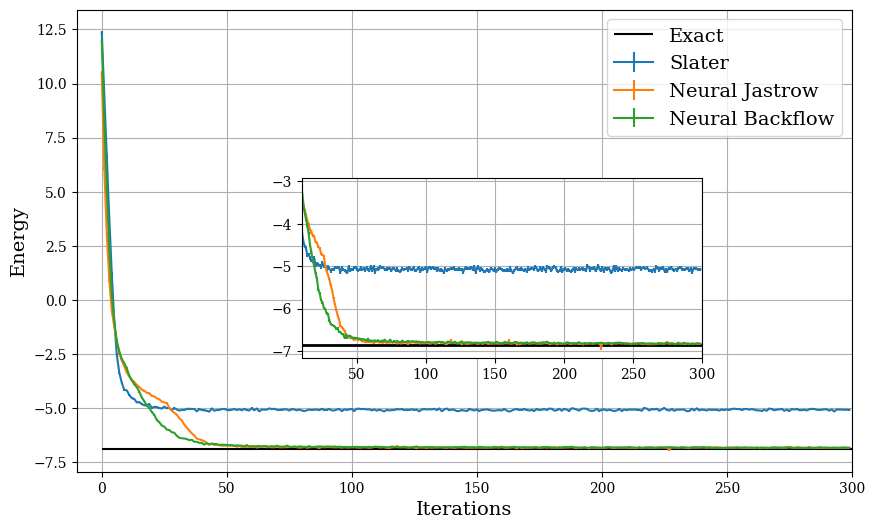

In [ ]:
logged_data = (slater_log.data,nj_log.data,bf_log.data)
labels = ("Slater","Neural Jastrow","Neural Backflow")

from matplotlib import pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rc('font', family = 'Serif', size = 14)
matplotlib.rc('xtick', labelsize = 10)
matplotlib.rc('ytick', labelsize = 10)
matplotlib.rcParams['figure.figsize'] = (10,6)

for data,label in zip(logged_data,labels):
    plt.errorbar(data["Energy"].iters, data["Energy"].Mean.real, yerr=data["Energy"].Sigma,label=label)

plt.hlines([E_gs], xmin=0, xmax=300, color='black', label="Exact")

plt.xlabel('Iterations')
plt.ylabel('Energy')
plt.legend()
plt.grid()
plt.xlim(-10,300)
#Zoomed Portion
sub_axes = plt.axes([0.35,0.3,0.4,0.3])
for data,label in zip(logged_data,labels):
    sub_axes.errorbar(data["Energy"].iters[10:], data["Energy"].Mean.real[10:], yerr=data["Energy"].Sigma[10:],label=label)
sub_axes.axhline(y=eig_vals[0], xmin=0, xmax=logged_data[0]["Energy"].iters[-1], linewidth=2, color="k", label="Exact")
plt.xlim(10,300)
plt.grid()
plt.show()

In [ ]:
print("Time Required for Different methods/ ansatz for same number of iteration")
print("------------------------------------------------------------------")
print(f"Slater Determinant  : {sd_time} seconds")
print(f"Neural Jastrow      : {nj_time} seconds")
print(f"Neural Backflow     : {bf_time} seconds")
print("------------------------------------------------------------------")

Time Required for Different methods/ ansatz for same number of iteration
------------------------------------------------------------------
Slater Determinant  : 265.2650525569916 seconds
Neural Jastrow      : 295.78839802742004 seconds
Neural Backflow     : 309.69594168663025 seconds
------------------------------------------------------------------


In [ ]:
print("Relative error for Different methods/ ansatz for same number of iteration")
print("------------------------------------------------------------------")
print(f"Slater Determinant  : {sd_error} ")
print(f"Neural Jastrow      : {nj_error} ")
print(f"Neural Backflow     : {bf_error} ")
print("------------------------------------------------------------------")

Relative error for Different methods/ ansatz for same number of iteration
------------------------------------------------------------------
Slater Determinant  : 0.2580067192020388 
Neural Jastrow      : 0.0065978970630699105 
Neural Backflow     : 0.003737125705837068 
------------------------------------------------------------------
